# 1) Preparation

## Imports

In [48]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio # for loading MATLAB files
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, filtfilt, iirnotch, sosfiltfilt, welch, resample, hilbert
from scipy.stats import mode

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## Load raw data

In [49]:
ninapro_path = 'data/DB3/'
npulse_path = 'data/pers_data/'

In [50]:
# Load all Ninapro data from folder "DB3"
data_ninapro = loadmat("data/DB3/DB3_s1/S1_E1_A1.mat")

# Load all personal data from folder "pers_data"
data_npulse = pd.read_csv("data/pers_data/raw/WS_R_4_250328165059.csv")


## Data preparation : functions

In [51]:
# # Action1 + Action2 -> Gesture
# def compute_flat_label(row):
#     if pd.isna(row['Action2']): # if Action2 is NaN, return Action1
#         return row['Action1']
#     elif ((row['Action1'] == 'Rest') and (not pd.isna(row['Action2']))): # if Action1 is Rest and Action2 is not NaN, return Action1
#         return row['Action2']
#     elif ((row['Action2'] == 'Rest') and (not pd.isna(row['Action1']))): # if Action2 is Rest and Action1 is not NaN, return Action2
#         return row['Action1']
#     else:
#         print("Error")
#         return row['Action1']

def compute_flat_label(row):
    if pd.isna(row['Action2']): # if Action2 is NaN, return Action1
        return row['Action1']
    else:
        return row['Action2']

In [52]:
# Downsample dataframe
def downsample_dataframe_with_labels(df, target_freq, time_col='Timestamp', label_cols=None, method='resample'):
    """
    Downsamples a DataFrame with timestamp, signal columns, and optional label columns.
    
    Parameters:
        df : pd.DataFrame
            Input data (must include a time column).
        target_freq : int
            Target sampling frequency in Hz.
        time_col : str
            Name of the time column.
        label_cols : list of str
            Columns with categorical labels (e.g., ['FlatLabel', 'Action1', 'Action2']).
        method : str
            'resample' (FFT-based) or 'average' (bin-average + mode for labels).
    
    Returns:
        pd.DataFrame
            Downsampled DataFrame with aligned time, signal, and label columns.
    """
    if time_col not in df.columns:
        raise ValueError(f"{time_col} must be in dataframe")

    label_cols = label_cols or []
    all_cols = df.columns.tolist()
    signal_cols = [col for col in all_cols if col not in [time_col] + label_cols]

    t_orig = df[time_col].values
    t_start, t_end = t_orig[0], t_orig[-1]
    duration = t_end - t_start
    n_target = int(duration * target_freq)

    # Downsample signals
    if method == 'resample':
        signals_ds = pd.DataFrame(
            resample(df[signal_cols].values, n_target),
            columns=signal_cols
        )
    elif method == 'average':
        df_indexed = df.set_index(time_col)
        df_indexed.index = pd.to_datetime(df_indexed.index, unit='s')
        signals_ds = df_indexed[signal_cols].resample(f"{int(1000/target_freq)}ms").mean().dropna().reset_index(drop=True)
    else:
        raise ValueError("method must be 'resample' or 'average'")

    # Generate new time vector
    t_uniform = np.linspace(t_start, t_end, n_target, endpoint=False)
    signals_ds.insert(0, time_col, t_uniform)

    # Downsample labels using mode per time bin
    if label_cols:
        df_label = df[[time_col] + label_cols].copy()
        df_label.index = pd.to_datetime(df_label[time_col], unit='s')

        bin_size_ms = int(1000 / target_freq)
        label_resampled = []

        for col in label_cols:
            grouped = df_label[col].resample(f"{bin_size_ms}ms").agg(
                lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan  # Handle empty mode
            )
            grouped = grouped.fillna(method='ffill')  # Forward-fill NaN values
            label_resampled.append(grouped)

        label_df = pd.concat(label_resampled, axis=1)
        label_df.columns = label_cols
        label_df = label_df.dropna().reset_index(drop=True)

        # Align label_df to signal df
        label_df = label_df.iloc[:len(signals_ds)]
        signals_ds[label_cols] = label_df

    return signals_ds

In [53]:
id_to_gesture = {
    0: "Rest",
    1: "ThumbUp",
    2: "Scisors",
    5: "Palm",
    6: "Fist",
    9: "WristRotIn",
    10: "WristRotExt",
    13: "WristFlexion",
    14: "WristExt",
}

npulse_gestures = {"Rest", "Fist", "WristFlexion", "WristExt", "WristRotIn", "WristRotExt", "Palm"}

gesture_to_id = {v: k for k, v in id_to_gesture.items() if v in npulse_gestures}

In [54]:
def hampel_filter(series, window_size=3, n_sigmas=3):
    """Applies Hampel filter to a 1D pandas Series."""
    L = 1.4826  # scale factor for Gaussian distribution
    rolling_median = series.rolling(window=2 * window_size + 1, center=True).median()
    diff = np.abs(series - rolling_median)
    mad = L * diff.rolling(window=2 * window_size + 1, center=True).median()
    
    # Identify outliers
    outlier_idx = diff > n_sigmas * mad
    filtered = series.copy()
    filtered[outlier_idx] = rolling_median[outlier_idx]
    return filtered

In [55]:
def clean_data(raw_data):
    cleaned_data = raw_data.copy()
    
    # Remove the first row
    cleaned_data = cleaned_data.drop(index=0)

    # Number of channels
    num_channels = 2

    # Compute the average sampling frequency and jitter
    sampling_freq = 1 / np.mean(np.diff(cleaned_data["Timestamp"]))
    jitter = np.mean(np.diff(cleaned_data["Timestamp"]))
    # print(f"Sampling Frequency: {sampling_freq} Hz")
    # print(f"Jitter: {jitter} seconds")

    for i in range(num_channels): # nb of channels
        channel = cleaned_data["Channel{}".format(i+1)]

        # Remove DC offset
        channel = (channel - np.mean(channel))

        # Filter 50Hz noise using a Hampel filter
        channel = hampel_filter(channel, window_size=100, n_sigmas=3)

        cleaned_data["Channel{}".format(i+1)] = channel
    
    return cleaned_data

## Data cleaning

### Ninapro

In [56]:
# Useful information about dataset
emg_rectified = data_ninapro["emg"]
stimulus = data_ninapro["stimulus"] 
repetition = data_ninapro["repetition"] 
restimulus = data_ninapro['restimulus']
rerepetition = data_ninapro['rerepetition']

n_stimuli = len(np.unique(restimulus)) - 1
n_repetitions = len(np.unique(rerepetition)) - 1 
n_channels = emg_rectified.shape[1]

In [57]:
# Create dataframe + add Timestamp column
data_ninapro_df = pd.DataFrame()

for channel in range(n_channels):
    data_ninapro_df[f'Channel{channel+1}'] = emg_rectified[:, channel].flatten()
    # data_ninapro_df['Stimulus'] = stimulus.flatten()
    # data_ninapro_df['Repetition'] = repetition.flatten()
    data_ninapro_df['Restimulus'] = restimulus.flatten()
    data_ninapro_df['Rerepetition'] = rerepetition.flatten()

sampling_rate = 2000  # Hz (Ninapro sampling rate)
n_samples = data_ninapro_df.shape[0]

data_ninapro_df['Timestamp'] = np.arange(n_samples) / sampling_rate  # Create a timestamp column

In [58]:
# Delete unused columns
data_ninapro_df.drop(columns=['Channel1', 'Channel3', 'Channel4', 'Channel5', 'Channel6', 'Channel7', 'Channel9', 'Channel10', 'Channel11', 'Channel12'], inplace=True)

# Keep selected stimuli (N-pulse stimuli)
data_ninapro_df = data_ninapro_df[data_ninapro_df['Restimulus'].isin(gesture_to_id.values())]

In [59]:
# Downsample
data_ninapro_downsampled = downsample_dataframe_with_labels(data_ninapro_df, target_freq=1000, time_col='Timestamp', label_cols=['Restimulus', 'Rerepetition'], method='resample')

In [60]:
# Rename columns and convert to int
data_ninapro_downsampled.rename(columns={'Restimulus': 'Gesture', 'Rerepetition': 'Repetition'}, inplace=True)
data_ninapro_downsampled['Gesture'] = data_ninapro_downsampled['Gesture'].astype(int)
data_ninapro_downsampled['Repetition'] = data_ninapro_downsampled['Repetition'].astype(int)

### N-pulse

In [61]:
# Filter data
data_npulse_filtered = clean_data(data_npulse)

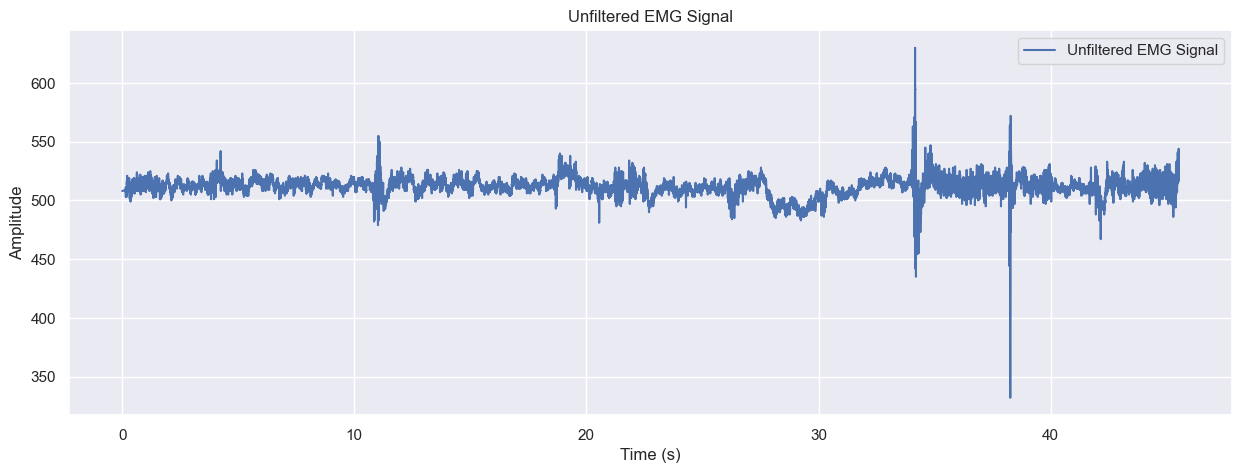

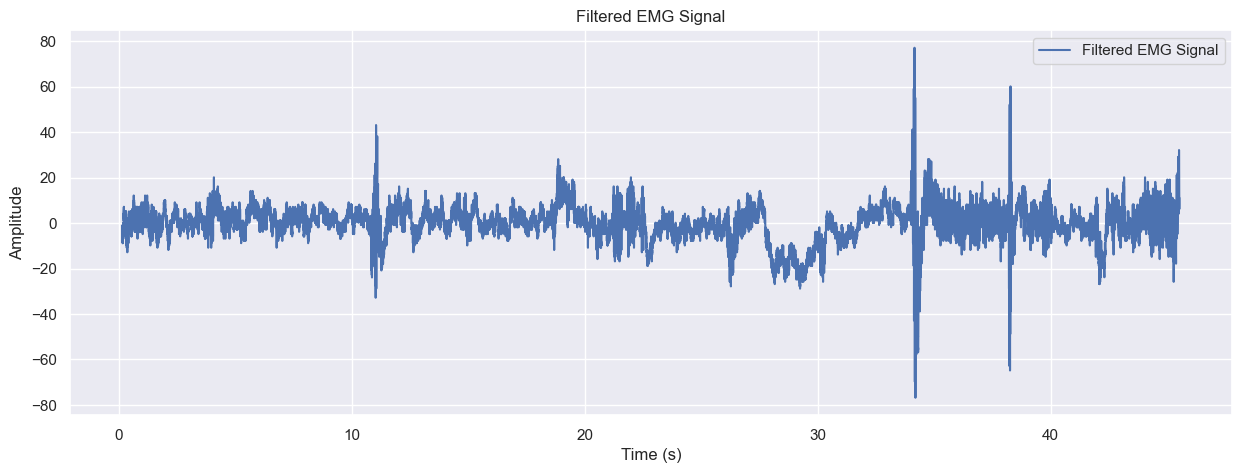

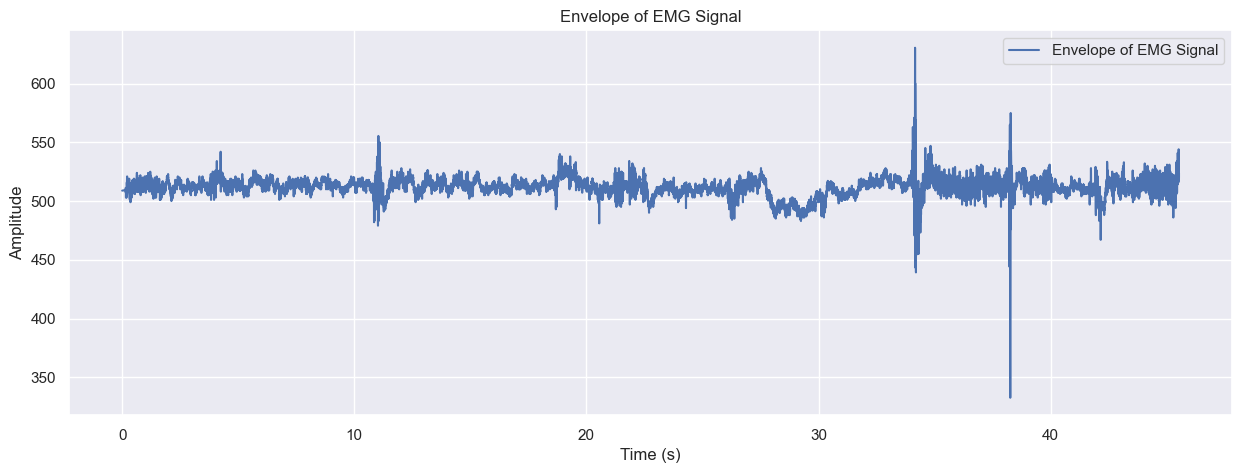

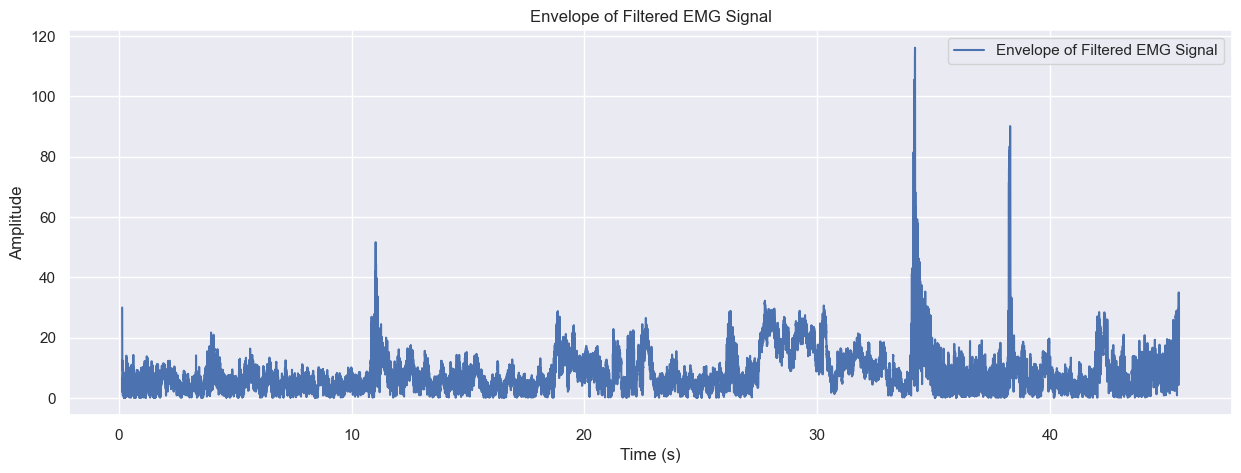

In [62]:
# Plot unfiltered data for npulse
plt.figure(figsize=(15, 5))
plt.plot(data_npulse['Timestamp'], data_npulse['Channel1'], label='Unfiltered EMG Signal')
plt.title('Unfiltered EMG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot filtered data for npulse
plt.figure(figsize=(15, 5))
plt.plot(data_npulse_filtered['Timestamp'], data_npulse_filtered['Channel1'], label='Filtered EMG Signal')
plt.title('Filtered EMG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

analytic_signal = hilbert(data_npulse['Channel1'])
envelope = np.abs(analytic_signal)
plt.figure(figsize=(15, 5))
plt.plot(data_npulse['Timestamp'], envelope, label='Envelope of EMG Signal')
plt.title('Envelope of EMG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

analytic_signal = hilbert(data_npulse_filtered['Channel1'])
envelope = np.abs(analytic_signal)
plt.figure(figsize=(15, 5))
plt.plot(data_npulse_filtered['Timestamp'], envelope, label='Envelope of Filtered EMG Signal')
plt.title('Envelope of Filtered EMG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()



In [63]:
# Gesture column
data_npulse_copy = data_npulse.copy()
data_npulse_copy.drop(index=0, inplace=True)
data_npulse_copy['Gesture'] = data_npulse_copy.apply(compute_flat_label, axis=1)
data_npulse_copy['Gesture'] = data_npulse_copy['Gesture'].map(gesture_to_id)
data_npulse_copy.drop(columns=['Action1', 'Action2'], inplace=True)

In [64]:
# Downsample
data_npulse_downsampled = downsample_dataframe_with_labels(data_npulse_copy, target_freq=1000, time_col='Timestamp', label_cols=['Gesture'], method='resample')


In [65]:
# Changing Gesture column to int
data_npulse_downsampled['Gesture'] = data_npulse_downsampled['Gesture'].astype(int)

In [66]:
# SNR normalization
rest_ninapro_channel2 = data_ninapro_downsampled[data_ninapro_downsampled['Gesture'] == 0]['Channel2']
rest_ninapro_channel8 = data_ninapro_downsampled[data_ninapro_downsampled['Gesture'] == 0]['Channel8']

rest_npulse_channel1 = data_npulse_downsampled[data_npulse_downsampled['Gesture'] == 0]['Channel1']
rest_npulse_channel2 = data_npulse_downsampled[data_npulse_downsampled['Gesture'] == 0]['Channel2']

scaling_factor_channel1 = np.sqrt(np.mean(rest_ninapro_channel2**2) / np.mean(rest_npulse_channel1**2))
scaling_factor_channel2 = np.sqrt(np.mean(rest_ninapro_channel8**2) / np.mean(rest_npulse_channel2**2))

data_npulse_downsampled['Channel1'] *= scaling_factor_channel1
data_npulse_downsampled['Channel2'] *= scaling_factor_channel2

## Save data

In [67]:
cleaned_ninapro_path = "data/cleaned/NINAPRO/"
cleaned_npulse_path = "data/cleaned/NPULSE/"

os.makedirs(cleaned_ninapro_path, exist_ok=True)
os.makedirs(cleaned_npulse_path, exist_ok=True)

data_ninapro_downsampled.to_csv(cleaned_ninapro_path + "cleaned_ninapro_df.csv", index=False)
data_npulse_downsampled.to_csv(cleaned_npulse_path + "cleaned_npulse_df.csv", index=False)

# 1.5) Verification

## Checking dataframe columns

In [68]:
data_ninapro_downsampled.head(10)

,Timestamp,Channel2,Channel8,Gesture,Repetition
0,0.000,-2.285929e-07,-0.000004,0,1
1,0.001,-1.780012e-06,-0.000004,0,1
2,0.002,-4.696690e-06,-0.000004,0,1
3,0.003,-2.146219e-06,-0.000003,0,1
4,0.004,1.890764e-06,-0.000003,0,1
5,0.005,2.021670e-06,-0.000004,0,1
6,0.006,2.087339e-06,-0.000006,0,1
7,0.007,3.130160e-06,-0.000006,0,1
8,0.008,3.534605e-06,-0.000004,0,1
9,0.009,2.239357e-06,-0.000003,0,1


In [69]:
data_npulse_downsampled.head(10)

,Timestamp,Channel1,Channel2,Gesture
0,0.154,0.000017,0.000025,0
1,0.155,0.000017,0.000025,0
2,0.156,0.000017,0.000025,0
3,0.157,0.000017,0.000025,0
4,0.158,0.000017,0.000025,0
5,0.159,0.000017,0.000025,0
6,0.160,0.000017,0.000025,0
7,0.161,0.000017,0.000025,0
8,0.162,0.000017,0.000025,0
9,0.163,0.000017,0.000025,0


In [70]:
# Count NaN values in each column
print("Ninapro Data NaN Count:")
print(data_ninapro_downsampled.isna().sum())

print("\nNpulse Data NaN Count:")
print(data_npulse_downsampled.isna().sum())


Ninapro Data NaN Count:
Timestamp     0
Channel2      0
Channel8      0
Gesture       0
Repetition    0
dtype: int64

Npulse Data NaN Count:
Timestamp    0
Channel1     0
Channel2     0
Gesture      0
dtype: int64


In [71]:
# Check the length of the dataframes
print(f"Ninapro Data Length: {len(data_ninapro_downsampled)}")
print(f"Npulse Data Length: {len(data_npulse_downsampled)}")

Ninapro Data Length: 912503
Npulse Data Length: 45372


## Samples for each gesture

In [72]:
for gesture in npulse_gestures:
    print(f"Gesture: {gesture}")
    id = gesture_to_id[gesture]
    ninapro_gesture = data_ninapro_downsampled[data_ninapro_downsampled['Gesture'] == id]
    npulse_gesture = data_npulse_downsampled[data_npulse_downsampled['Gesture'] == id]

    print(f"Ninapro Data Length: {len(ninapro_gesture)}")
    print(f"Npulse Data Length: {len(npulse_gesture)}")

Gesture: Palm
Ninapro Data Length: 39040
Npulse Data Length: 3827
Gesture: Fist
Ninapro Data Length: 39087
Npulse Data Length: 4131
Gesture: WristFlexion
Ninapro Data Length: 19336
Npulse Data Length: 3963
Gesture: WristExt
Ninapro Data Length: 39144
Npulse Data Length: 3637
Gesture: WristRotExt
Ninapro Data Length: 13600
Npulse Data Length: 3946
Gesture: WristRotIn
Ninapro Data Length: 38953
Npulse Data Length: 3876
Gesture: Rest
Ninapro Data Length: 723343
Npulse Data Length: 21992


## Correspondance Ninapro and N-pulse

Ninapro Gesture 1 Channel 2 Length: 39087
Ninapro Gesture 1 Channel 8 Length: 39087
Npulse Gesture 1 Channel 1 Length: 4131
Npulse Gesture 1 Channel 2 Length: 4131


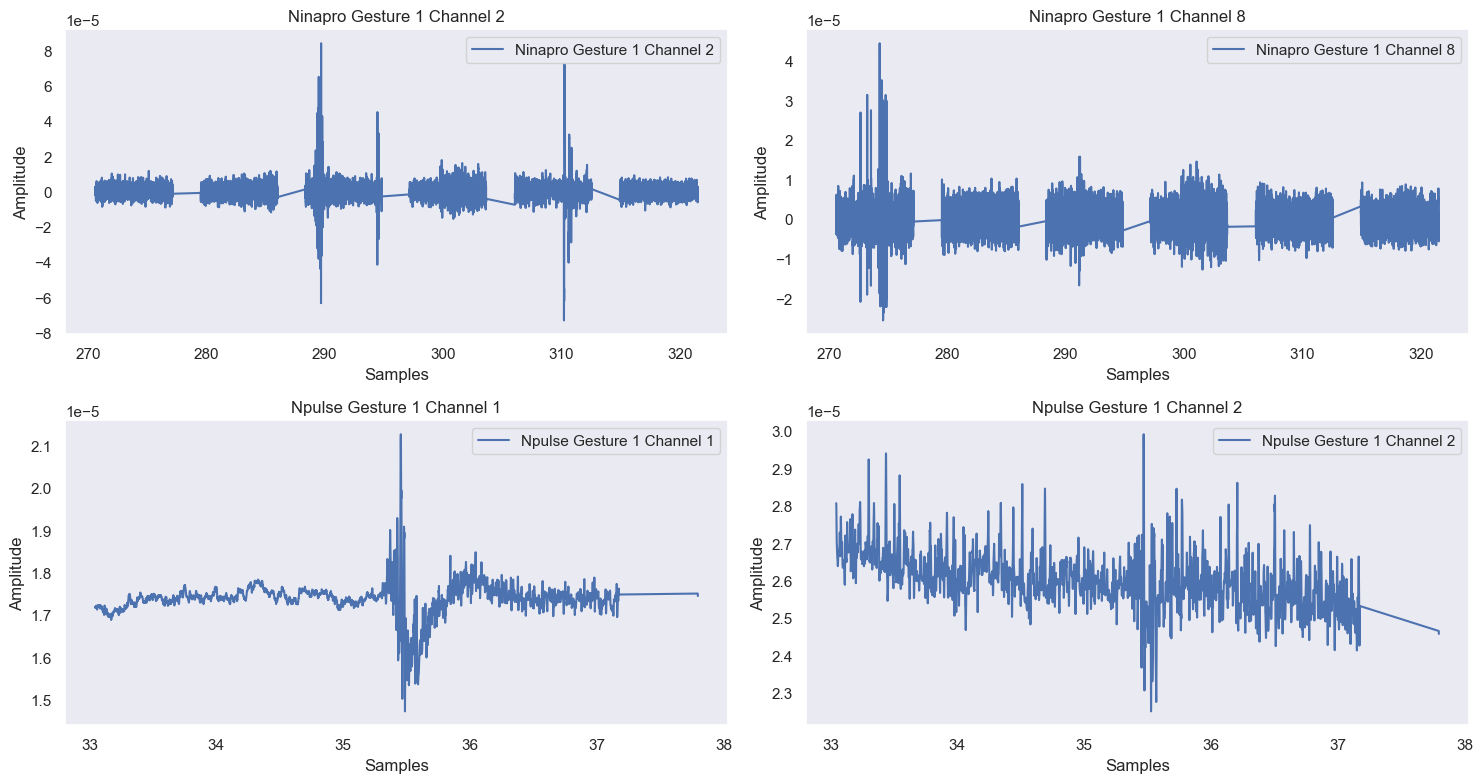

In [73]:
ninapro_gesture1 = data_ninapro_downsampled[data_ninapro_downsampled['Gesture'] == 6]
npulse_gesture1 = data_npulse_downsampled[data_npulse_downsampled['Gesture'] == 6]

print(f"Ninapro Gesture 1 Channel 2 Length: {len(ninapro_gesture1['Channel2'])}")
print(f"Ninapro Gesture 1 Channel 8 Length: {len(ninapro_gesture1['Channel8'])}")
print(f"Npulse Gesture 1 Channel 1 Length: {len(npulse_gesture1['Channel1'])}")
print(f"Npulse Gesture 1 Channel 2 Length: {len(npulse_gesture1['Channel2'])}")

# Plotting the signals
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(ninapro_gesture1['Timestamp'], ninapro_gesture1['Channel2'], label='Ninapro Gesture 1 Channel 2')
plt.title('Ninapro Gesture 1 Channel 2')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.subplot(2, 2, 2)
plt.plot(ninapro_gesture1['Timestamp'], ninapro_gesture1['Channel8'], label='Ninapro Gesture 1 Channel 8')
plt.title('Ninapro Gesture 1 Channel 8')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.subplot(2, 2, 3)
plt.plot(npulse_gesture1['Timestamp'], npulse_gesture1['Channel1'], label='Npulse Gesture 1 Channel 1')
plt.title('Npulse Gesture 1 Channel 1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.subplot(2, 2, 4)
plt.plot(npulse_gesture1['Timestamp'], npulse_gesture1['Channel2'], label='Npulse Gesture 1 Channel 2')
plt.title('Npulse Gesture 1 Channel 2')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# 2) Model

## Load preprocessed data

In [74]:
cleaned_ninapro_path = "data/cleaned/NINAPRO/"
cleaned_npulse_path = "data/cleaned/NPULSE/"

training_data = pd.read_csv(cleaned_ninapro_path + "cleaned_ninapro_df.csv")
testing_data = pd.read_csv(cleaned_npulse_path + "cleaned_npulse_df.csv")

## Features

In [75]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Variance
var = lambda x: np.var(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1] * np.diff(x, axis=0)[1:]) < 0, axis=0)
# Zero Crossing (ZC)
def zero_crossing(x):
    return np.sum(np.diff(np.sign(x), axis=0) != 0)
zc = lambda x: zero_crossing(x)
# Log detector
log_det = lambda x: np.exp(1/len(x) * np.sum(np.log(x), axis=0))
# Willison amplitude
willison = lambda x: np.sum((x > 0.2*std(x)), axis=0)

# Frequency domain features (FFT-based)
fft_values = lambda x: np.fft.fft(x, axis=0)
fft_magnitude = lambda x: np.abs(fft_values(x))
fft_power = lambda x: np.square(fft_magnitude(x))
freqs = lambda x: np.fft.fftfreq(x.shape[0], d=1/1000)  # Assuming a sampling rate of 1000 Hz
# Total power
total_power = lambda x: np.sum(fft_power(x), axis=0)  
# Mean frequency
mean_freq = lambda x: np.sum(freqs(x) * fft_power(x), axis=0) / np.sum(fft_power(x), axis=0) 
# Median frequency
median_freq = lambda x: np.median(freqs(x) * fft_power(x), axis=0) 
# Peak frequency 
peak_freq = lambda x: freqs(x)[np.argmax(fft_power(x), axis=0)]  

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)

features_selected = [total_power, mav, rms, mean_freq]

In [76]:
def extract_features_and_labels(data, features, window=200, step_size=50):
    X = data.copy()
    X.drop(columns=['Gesture', 'Timestamp'], inplace=True)
    if 'Repetition' in X.columns:
        X.drop(columns=['Repetition'], inplace=True)
    y = data['Gesture']
    
    features_list = []
    labels_list = []

    for i in range(0, len(data) - window + 1, step_size):
        window_data = data.iloc[i:i + window]

        # analytic_signal = hilbert(data_npulse_filtered['Channel1'])
        # envelope = np.abs(analytic_signal)

        envelope_data = pd.DataFrame()
        for channel in X.columns:
            envelope_data[channel] = np.abs(hilbert(window_data[channel].values))

        feature_vector = [feature(envelope_data[channel].values) for channel in X.columns for feature in features]
        # feature_vector = [feature(window_data[channel].values) for channel in X.columns for feature in features]

        features_list.append(feature_vector)
        labels_list.append(window_data['Gesture'].values[0])
    
    return np.array(features_list), np.array(labels_list)

In [82]:
def balance_rest(df, label_col='Gesture', rest_label='Rest', target_rest_ratio=0.5):
    """
    Reduces the amount of 'Rest' class to balance dataset.
    
    Parameters:
        df : pd.DataFrame
            Input dataframe with labels
        label_col : str
            Name of label column
        rest_label : str
            The label value corresponding to Rest
        target_rest_ratio : float
            Target fraction of Rest samples after balancing (e.g., 0.5 = 50% of dataset)

    Returns:
        pd.DataFrame
            Balanced dataframe
    """
    rest_df = df[df[label_col] == rest_label]
    gesture_df = df[df[label_col] != rest_label]

    n_gesture = len(gesture_df)
    n_target_rest = int(n_gesture * target_rest_ratio / (1 - target_rest_ratio))

    if n_target_rest > len(rest_df):
        print("Warning: not enough Rest samples to achieve target ratio.")
        return df

    rest_sampled = rest_df.sample(n=n_target_rest, random_state=42)

    balanced_df = pd.concat([rest_sampled, gesture_df]).sort_index()
    return balanced_df


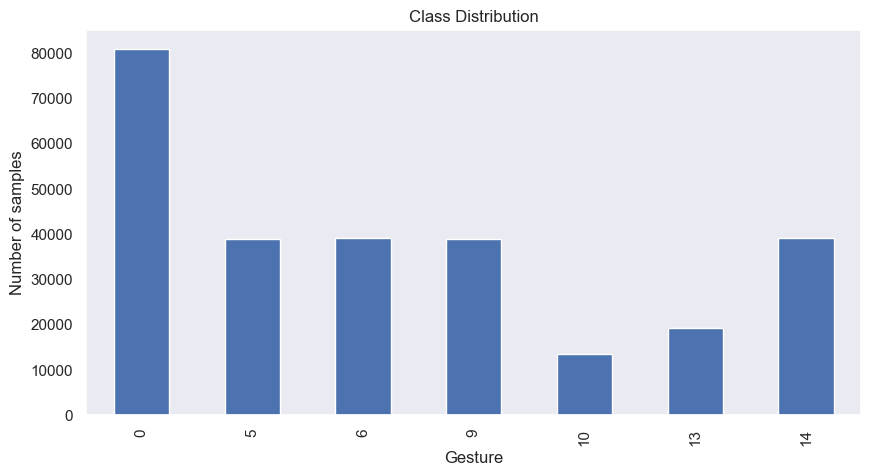

In [84]:
balanced_train_data = balance_rest(training_data, label_col='Gesture', rest_label=0, target_rest_ratio=0.3)

# Count each label
label_counts = balanced_train_data['Gesture'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
label_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Gesture")
plt.ylabel("Number of samples")
plt.grid()
plt.show()

In [85]:
time_window = 600 # 200 ms
time_sliding = 300 # 100 ms

fs = 1000 # Sampling frequency in Hz

window = int(time_window * fs / 1000) # Convert to samples
step = int(time_sliding * fs / 1000) # Convert to samples

training_features, training_labels = extract_features_and_labels(balanced_train_data, features_selected, window=window, step_size=step)
testing_features, testing_labels = extract_features_and_labels(testing_data, features_selected, window=window, step_size=step)

In [86]:
# Feature normalization
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
testing_features = scaler.transform(testing_features) 

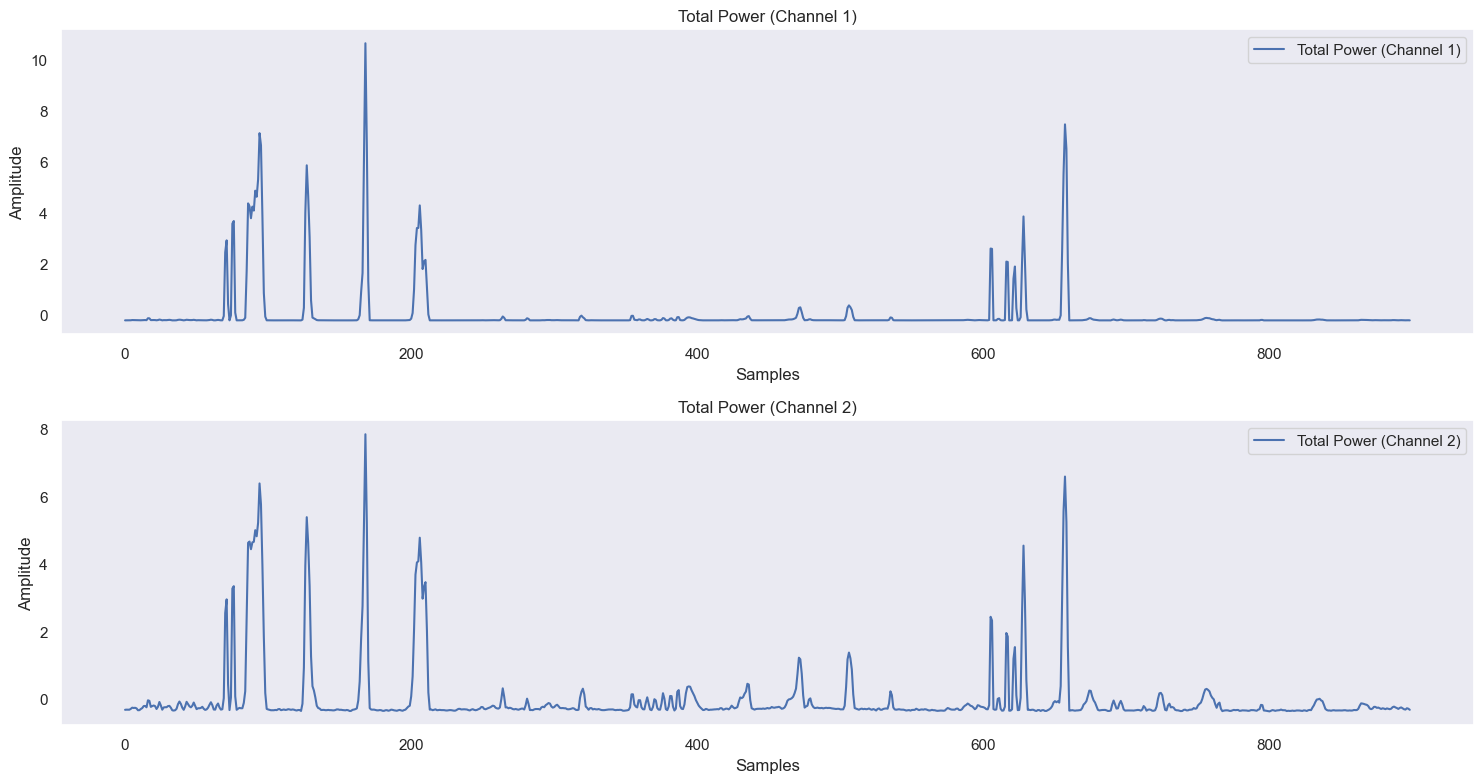

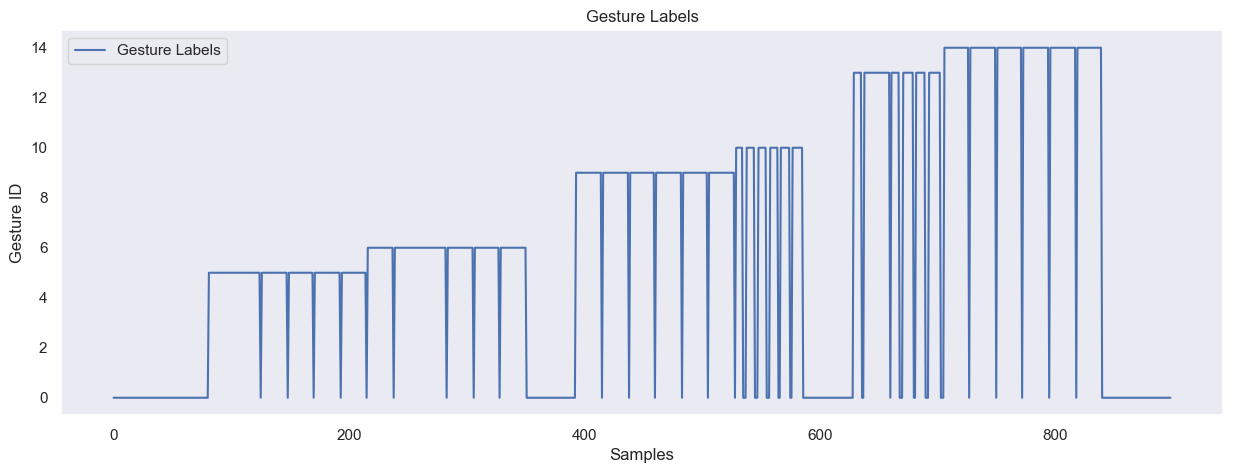

In [87]:
# Plot features of training data
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(training_features[:, 0], label='Total Power (Channel 1)')
plt.title('Total Power (Channel 1)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(training_features[:, 1], label='Total Power (Channel 2)')
plt.title('Total Power (Channel 2)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot labels of training data
plt.figure(figsize=(15, 5))
plt.plot(training_labels, label='Gesture Labels')
plt.title('Gesture Labels')
plt.xlabel('Samples')
plt.ylabel('Gesture ID')
plt.legend()
plt.grid()
plt.show()

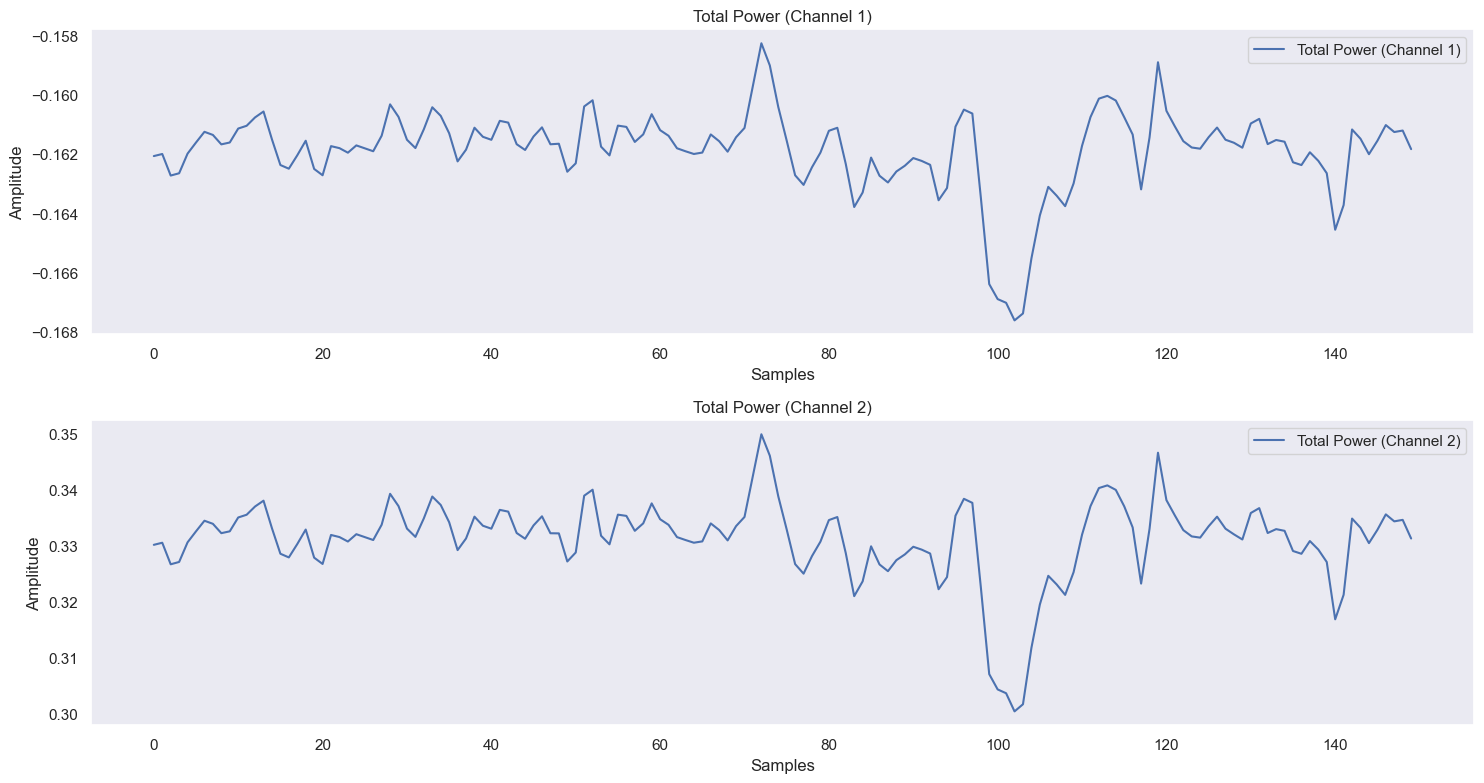

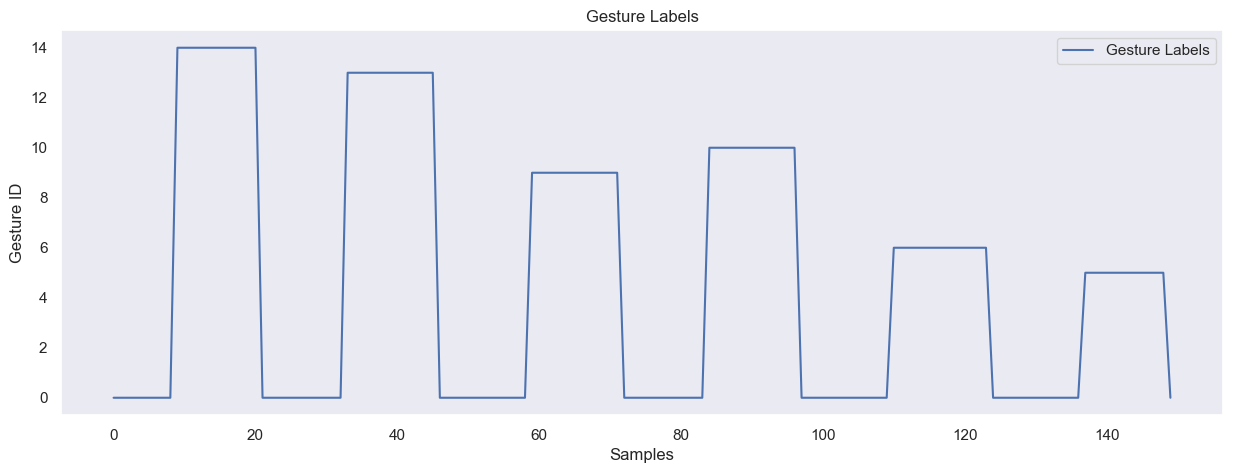

In [88]:
# Plot features of testing data
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(testing_features[:, 0], label='Total Power (Channel 1)')
plt.title('Total Power (Channel 1)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(testing_features[:, 1], label='Total Power (Channel 2)')
plt.title('Total Power (Channel 2)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot labels of training data
plt.figure(figsize=(15, 5))
plt.plot(testing_labels, label='Gesture Labels')
plt.title('Gesture Labels')
plt.xlabel('Samples')
plt.ylabel('Gesture ID')
plt.legend()
plt.grid()
plt.show()

## Training

In [89]:
# Define the Random Forest model
rf = RandomForestClassifier()

# Hyperparameter optimization using Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    # 'n_estimators': [50],
    # 'max_depth': [10],
    # 'min_samples_split': [2],
    # 'min_samples_leaf': [2],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(training_features, training_labels)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train the model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(training_features, training_labels)


Fitting 2 folds for each of 81 candidates, totalling 162 fits
Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10)

# 3) Performance

Accuracy score: 0.12
Recall score: 0.15264187866927595
F1 score: 0.041823155747206374


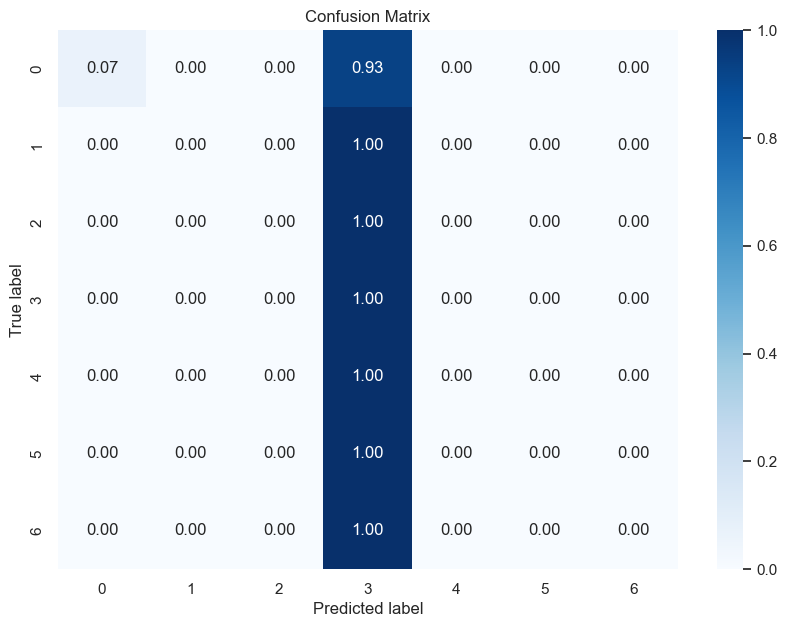

In [90]:
# Evaluate the model
y_pred = best_rf.predict(testing_features)
accuracy = accuracy_score(testing_labels, y_pred)
print(f"Accuracy score: {accuracy}")
print(f"Recall score: {recall_score(testing_labels, y_pred, average='macro')}")
print(f"F1 score: {f1_score(testing_labels, y_pred, average='macro')}")

# Confusion matrix
confmat = confusion_matrix(testing_labels, y_pred, normalize="true")
plt.figure(figsize=(10, 7))
sns.heatmap(confmat, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()